# Automatic Sentiment Analysis for Movie Reviews

## Table of contents

- [Introduction](#introduction)
- [Objectives](#objectives)
- [Initialization](#initialization)
- [Load Data](#load-data)
- [EDA](#eda)
- [Evaluation Procedure](#evaluation-procedure)
- [Normalization](#normalization)
- [Training / Testing Split](#training-testing-split)
- [Models](#models)
  - [Model 0 - Constant](#model-0---constant)
  - [Model 1 - NLTK, TF-IDF and LR](#model-1---nltk-tf-idf-and-lr)
  - [Model 3 - spaCy, TF-IDF and LR](#model-3---spacy-tf-idf-and-lr)
  - [Model 4 - spaCy, TF-IDF and LGBMClassifier](#model-4---spacy-tf-idf-and-lgbmclassifier)
  - [Model 9 - BERT](#model-9---bert)
- [My Reviews](#my-reviews)
  - [Model 2](#model-2)
  - [Model 3](#model-3)
  - [Model 4](#model-4)
  - [Model 9](#model-9)
- [Conclusions](#conclusions)


## Introduction

Using a labeled dataset from IMDB, this project entails developing a machine learning model to automatically categorize movie reviews as either positive or negative. To get an F1 score of at least 0.85, the text data must be preprocessed, vectorization techniques must be used, and multiple classification models must be trained. The dataset will be examined, class imbalances will be addressed, at least three distinct models will be trained, and their performance will be assessed using a variety of indicators. The finished model will be used to categorize fresh reviews and offer information on how well various strategies work.

## Objectives

- __Data Preprocessing & Vectorization__: To turn the IMDB reviews into numerical representations, load the dataset, tidy it up, address any class imbalances, and use the appropriate text vectorization algorithms.

- __Training and Evaluation of the Models__: Train a minimum of three distinct machine learning models (e.g., logistic regression, gradient boosting, etc.), assess how well they perform on the test set, and make sure that the F1 score is 0.85 or more.

- __Model Comparison & Analysis__: Determine which model works best for sentiment analysis by classifying fresh movie reviews using the trained models, comparing their performances, and examining the variations in the outcomes.

## Inicialization

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'


plt.style.use('seaborn')

In [3]:

tqdm.pandas()

## Load data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
# Display the first rows of the DataFrame
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [6]:
# Information about columns and data types
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [7]:
# Remove rows with null values in the 'average_rating' and 'votes' columns
df_reviews = df_reviews.dropna(subset=['average_rating', 'votes'])

# Check for null values in each column
print(df_reviews.isnull().sum())

# Print a separation line with a clearer comment
print("="*30)

# Remove duplicates if necessary
df_reviews = df_reviews.drop_duplicates()

# Check for duplicate rows
print(f"Duplicate rows removed: {df_reviews.duplicated().sum()}")

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     0
votes              0
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64
Duplicate rows removed: 0


## EDA

Let's check the number of movies and reviews over the years.

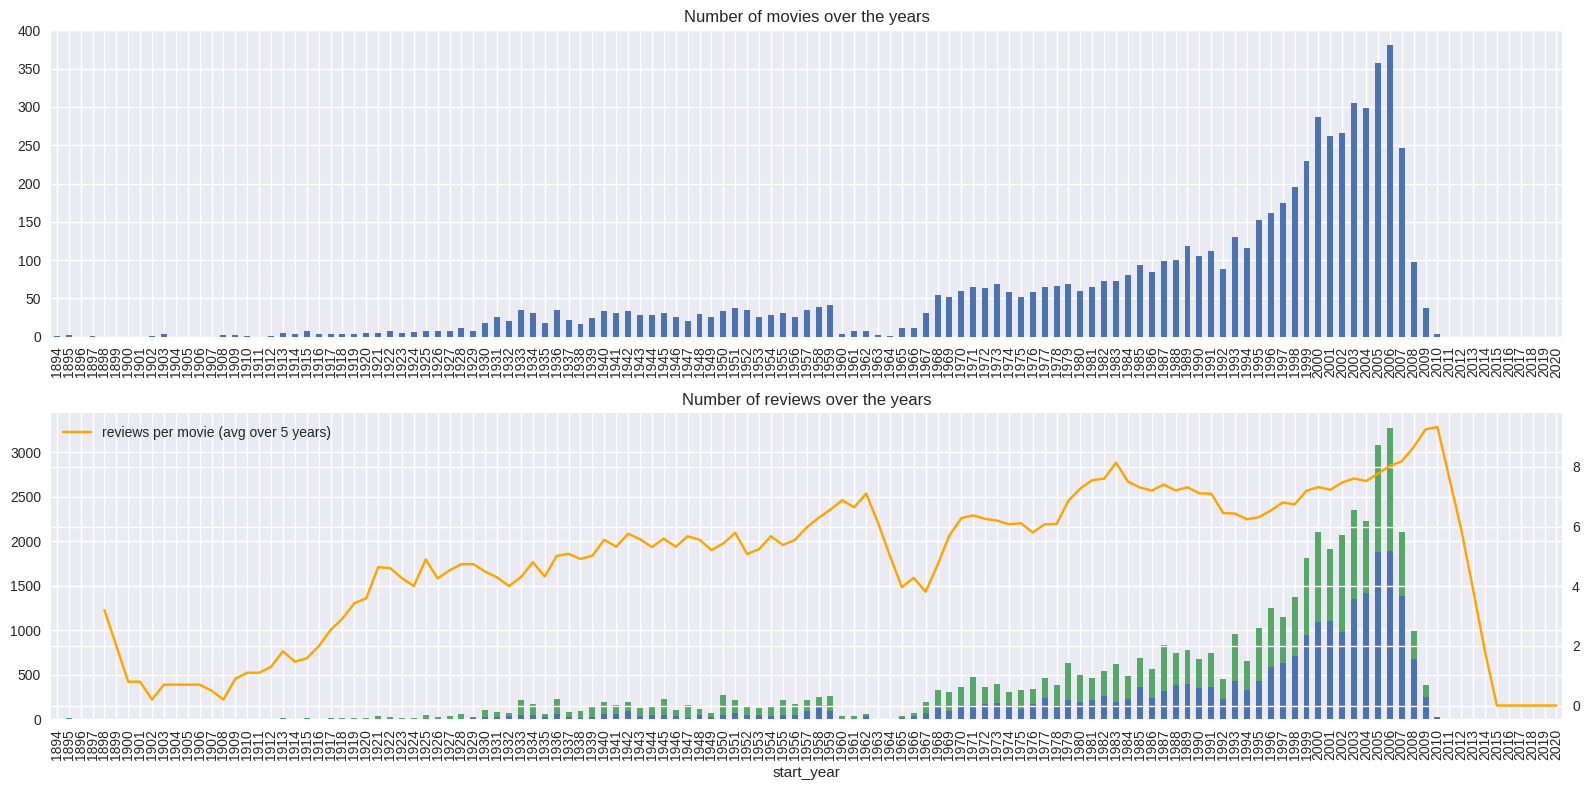

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

# Top plot: number of movies over the years
ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of movies over the years')

# Bottom plot: number of reviews and average reviews per movie
ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

# Reviews per movie
dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2 / dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

# Legends and titles
lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of reviews over the years')

fig.tight_layout()

Let's see the distribution of the number of reviews per movie with the exact count and KDE (just to see how it might differ from the exact coun

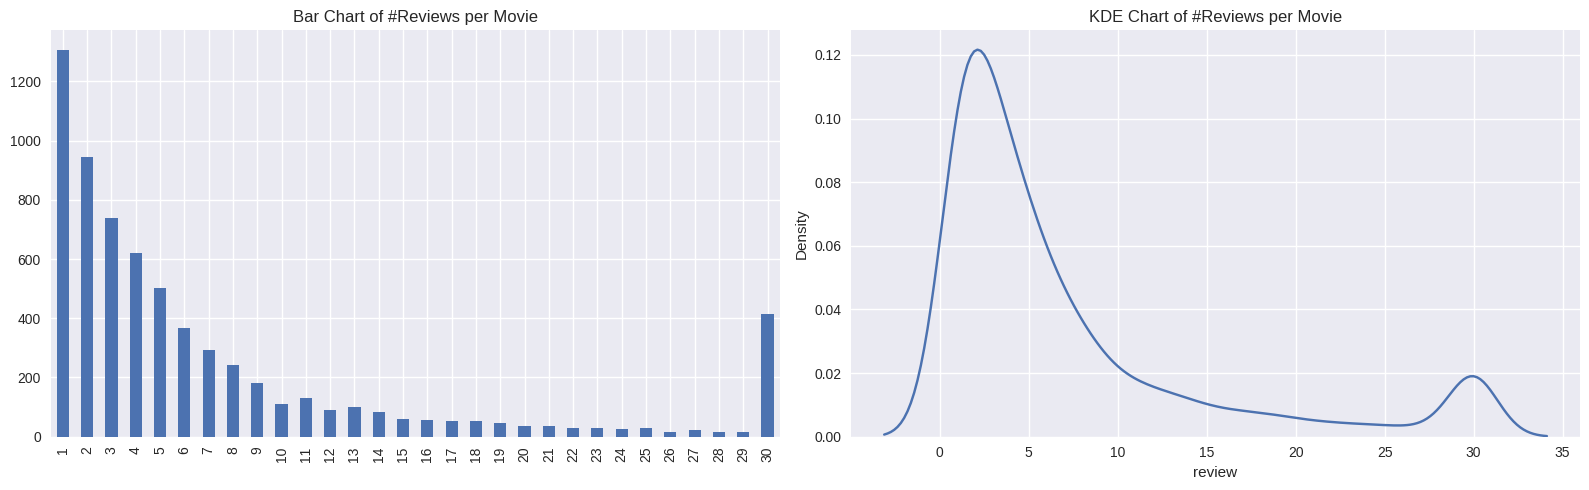

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plot the bar chart of #Reviews per movie
ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Chart of #Reviews per Movie')

# Plot the KDE chart of #Reviews per movie
ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Chart of #Reviews per Movie')

fig.tight_layout()

In these graphs, we can analyze that as time progresses, more movies are being released each year, which is visible in our first graph. In the second graph, we can see the number of reviews per movie, with an average of 2000 reviews per release.

Our available datasets have a column called `ds_part`, which specifies the information that should be used in both our training and test sets.

In [10]:
df_reviews['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

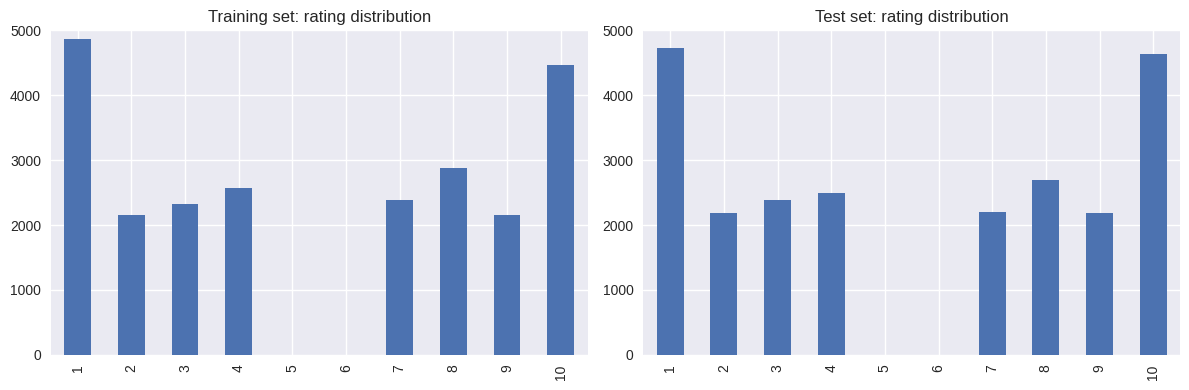

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Training set: distribution of ratings
ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Training set: rating distribution')

# Test set: distribution of ratings
ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Test set: rating distribution')

fig.tight_layout()

The training and test sets have similar distributions.

Distribution of negative and positive reviews over the years for two parts of the dataset.

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


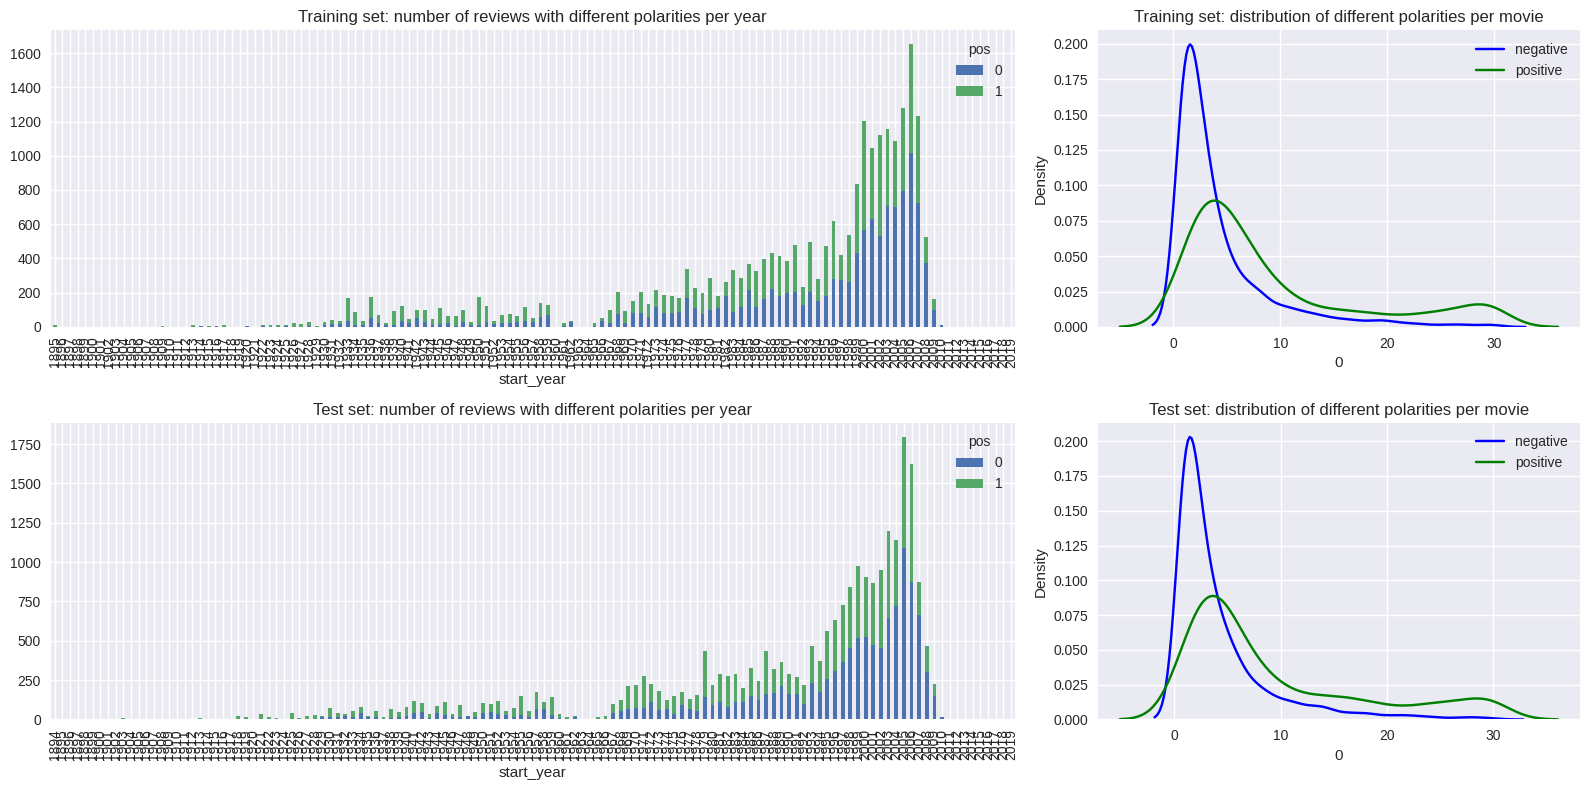

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

# First subplot: Training set - number of reviews by polarity per year
ax = axs[0][0]
dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Training set: number of reviews with different polarities per year')

# Second subplot: Training set - distribution of different polarities per movie
ax = axs[0][1]
dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('Training set: distribution of different polarities per movie')

# Third subplot: Test set - number of reviews by polarity per year
ax = axs[1][0]
dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Test set: number of reviews with different polarities per year')

# Fourth subplot: Test set - distribution of different polarities per movie
ax = axs[1][1]
dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('Test set: distribution of different polarities per movie')

fig.tight_layout()

The distributions of the reviews show mostly negative peaks; however, after stabilizing, there are more positive reviews than negative ones.

## Evaluation Procedure

Composition of an evaluation routine that can be used for all models in this project.

In [13]:
import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba >= threshold) for threshold in f1_thresholds]

        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Value
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # set crosses for some thresholds        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Value') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # set crosses for some thresholds        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # set crosses for some thresholds        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return df_eval_stats['test']

## Normalization

We assume that all the models below accept text in lowercase and without digits, punctuation, etc.

In [14]:
import re

def clear_text(text):     
    pattern = r"[^a-zA-Z']"
    text = re.sub(pattern, " ", text)
    text = text.split()
    text = " ".join(text)
    text = text.lower()
    return text

df_reviews['review_norm'] =df_reviews['review'].apply(clear_text)
df_reviews[['review','review_norm']]

,review,review_norm
0,The pakage implies that Warren Beatty and Gold...,the pakage implies that warren beatty and gold...
1,How the hell did they get this made?! Presenti...,how the hell did they get this made presenting...
2,There is no real story the film seems more lik...,there is no real story the film seems more lik...
3,Um .... a serious film about troubled teens in...,um a serious film about troubled teens in sing...
4,I'm totally agree with GarryJohal from Singapo...,i'm totally agree with garryjohal from singapo...
...,...,...
47326,This is another of my favorite Columbos. It sp...,this is another of my favorite columbos it spo...
47327,Talk about being boring! I got this expecting ...,talk about being boring i got this expecting a...
47328,"I never thought I'd say this about a biopic, b...",i never thought i'd say this about a biopic bu...
47329,Spirit and Chaos is an artistic biopic of Miya...,spirit and chaos is an artistic biopic of miya...


## Training / Testing Split

Fortunately, the entire dataset is already divided into training/testing parts; 'ds_part' is the corresponding indicator.

In [15]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

# Training features and target
train_features = df_reviews_train['review_norm']
train_target = df_reviews_train['pos']

# Test features and target
test_features = df_reviews_test['review_norm']
test_target = df_reviews_test['pos']

## Models

### Model 0 - Constant

In [16]:
from sklearn.dummy import DummyClassifier

In [17]:
model_1=DummyClassifier()
model_1.fit(train_features, train_target)

DummyClassifier()

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


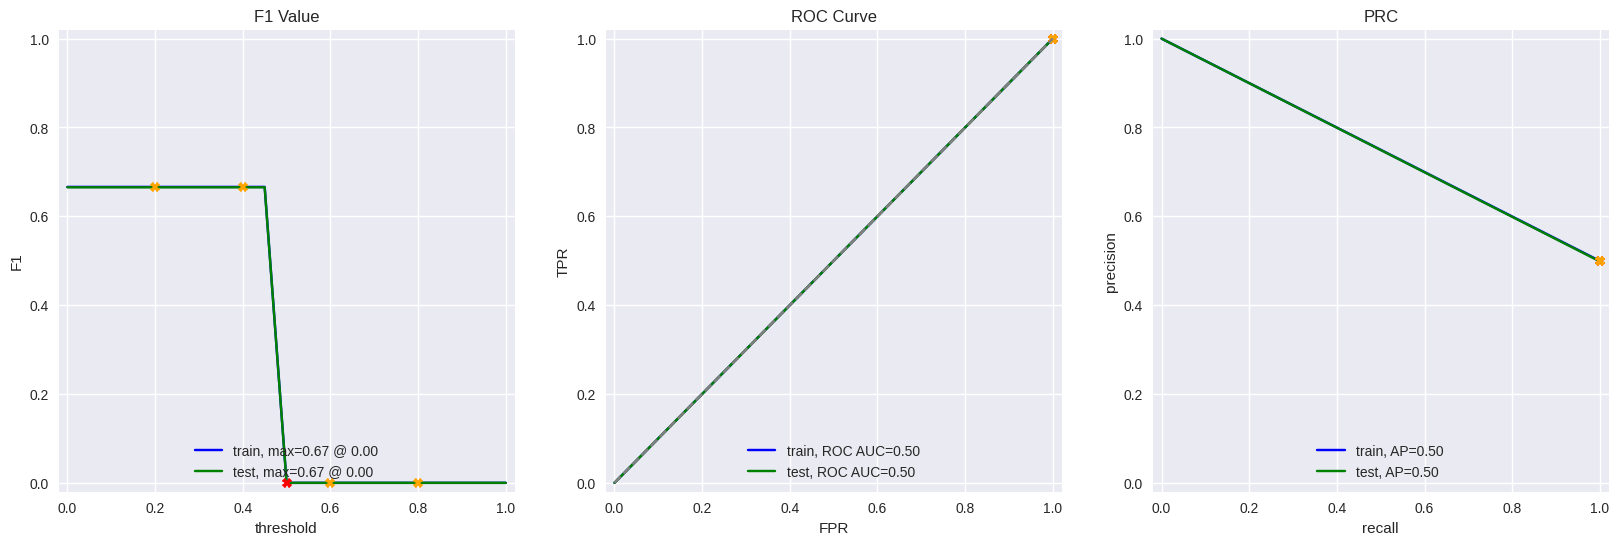

In [18]:
precision_1,f1_1,aps_1,roc_1=evaluate_model(model_1, train_features, train_target, test_features, test_target)

As expected, this model is not the right one; it seems that it could only predict correctly 50% of the time.

### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [19]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

          train  test
Accuracy   0.92  0.88
F1         0.92  0.88
APS        0.97  0.95
ROC AUC    0.97  0.95


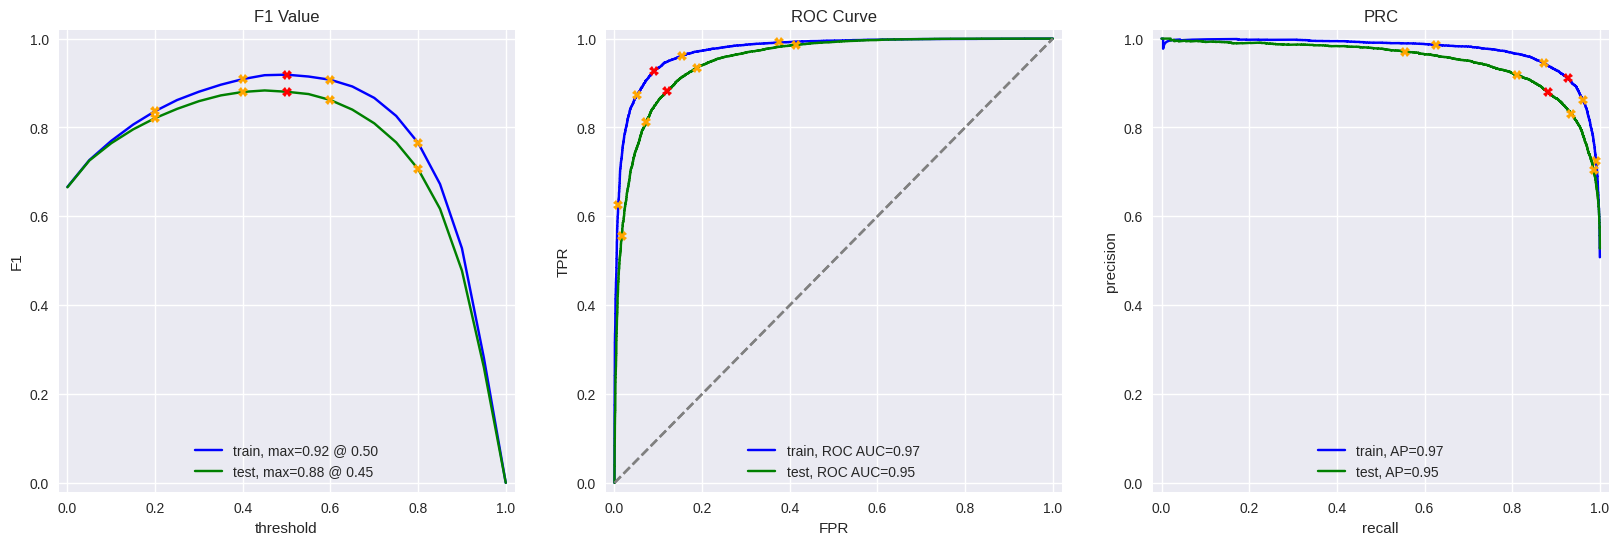

In [20]:
# Step 1: Preprocess the text to remove stopwords
stop_words = set(stopwords.words('english'))  

def preprocess_text(text):
    # Convert the text to lowercase, remove punctuation, and remove stopwords
    text = text.lower()  # Convert to lowercase
    words = text.split()  # Split the text into words
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return ' '.join(words)  # Rebuild the processed text

# Apply preprocessing on reviews
df_reviews_train['review_norm'] = df_reviews_train['review'].apply(preprocess_text)
df_reviews_test['review_norm'] = df_reviews_test['review'].apply(preprocess_text)

# Step 2: TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)  # Limit the number of features to 5000
X_train_vec = vectorizer.fit_transform(df_reviews_train['review_norm'])
X_test_vec = vectorizer.transform(df_reviews_test['review_norm'])

# Step 3: Train the Logistic Regression model
log_reg_model = LogisticRegression(max_iter=1000)
log_reg_model.fit(X_train_vec, train_target)

# Step 4: Make predictions and evaluate the model
y_pred = log_reg_model.predict(X_test_vec)

# Show the results
df_test_eval = evaluate_model(log_reg_model, X_train_vec, train_target, X_test_vec, test_target)


This model performs quite well, achieving an accuracy of 88% and an F1 score of 0.88 on the test data. Additionally, we notice that this model shows slight overfitting, as its performance on the training data exceeds that on the new test data.

This model already meets the requirements (F1 > 0.85), but next, we will analyze the performance of other models.

### Model 3 - spaCy, TF-IDF y LR

In [21]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [22]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

          train  test
Accuracy   0.91  0.88
F1         0.91  0.88
APS        0.97  0.95
ROC AUC    0.97  0.95


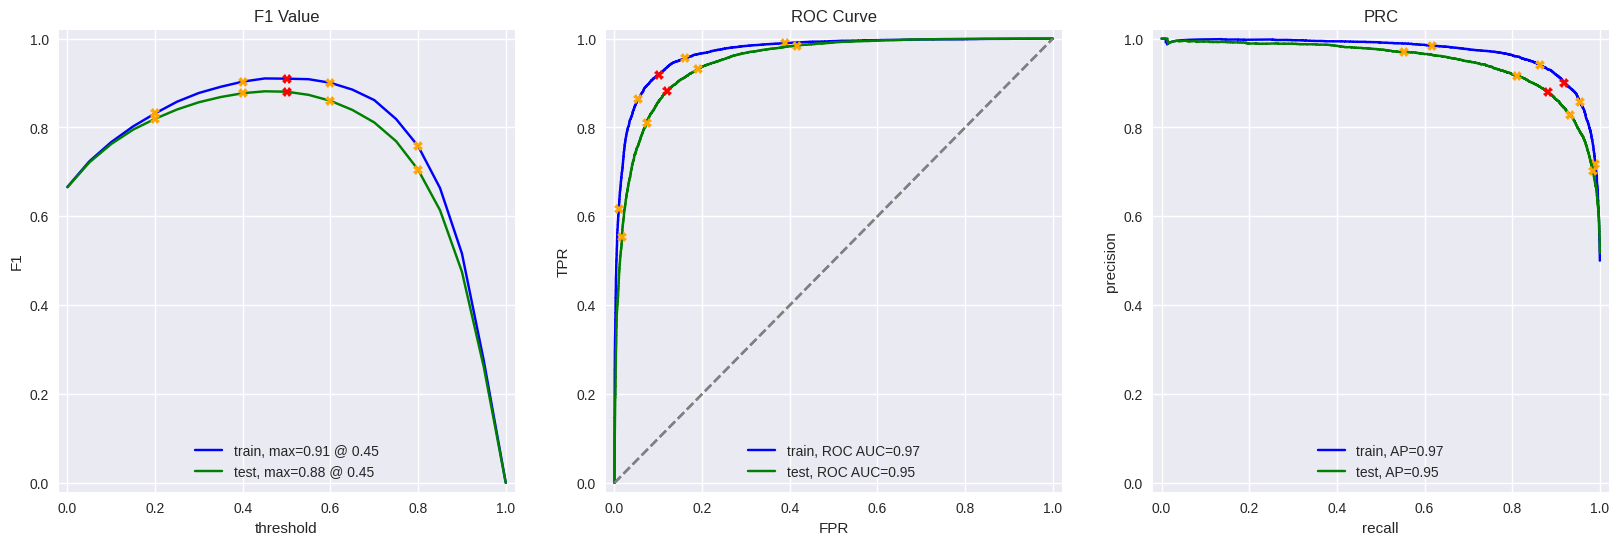

In [23]:
# Step 1: Preprocess the training and test data
df_reviews_train['review_processed'] = df_reviews_train['review'].apply(text_preprocessing_3)
df_reviews_test['review_processed'] = df_reviews_test['review'].apply(text_preprocessing_3)

# Step 2: Vectorize the reviews
vectorizer_3 = TfidfVectorizer(max_features=5000)  # Limit to 5000 features
X_train_vec_3 = vectorizer_3.fit_transform(df_reviews_train['review_processed'])
X_test_vec_3 = vectorizer_3.transform(df_reviews_test['review_processed'])

# Step 3: Create and train the logistic regression model
model_3 = LogisticRegression(max_iter=1000)
model_3.fit(X_train_vec_3, train_target)

# Step 4: Make predictions on the test data
predictions_3 = model_3.predict(X_test_vec_3)

# Step 5: Evaluate the model
eval_results_3 = evaluate_model(model_3, X_train_vec_3, train_target, X_test_vec_3, test_target)

The performance of this model is almost comparable to that of model 2, achieving an accuracy of 88% and an F1 score of 0.88 for the test data. Additionally, we notice that this model shows slight overfitting, which is lower than the overfitting seen in model 2.

This model already meets the requirements (F1 > 0.85); however, we will analyze the behavior of other models.


### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

In [24]:
from lightgbm import LGBMClassifier

          train  test
Accuracy   0.92  0.86
F1         0.92  0.86
APS        0.98  0.93
ROC AUC    0.98  0.94


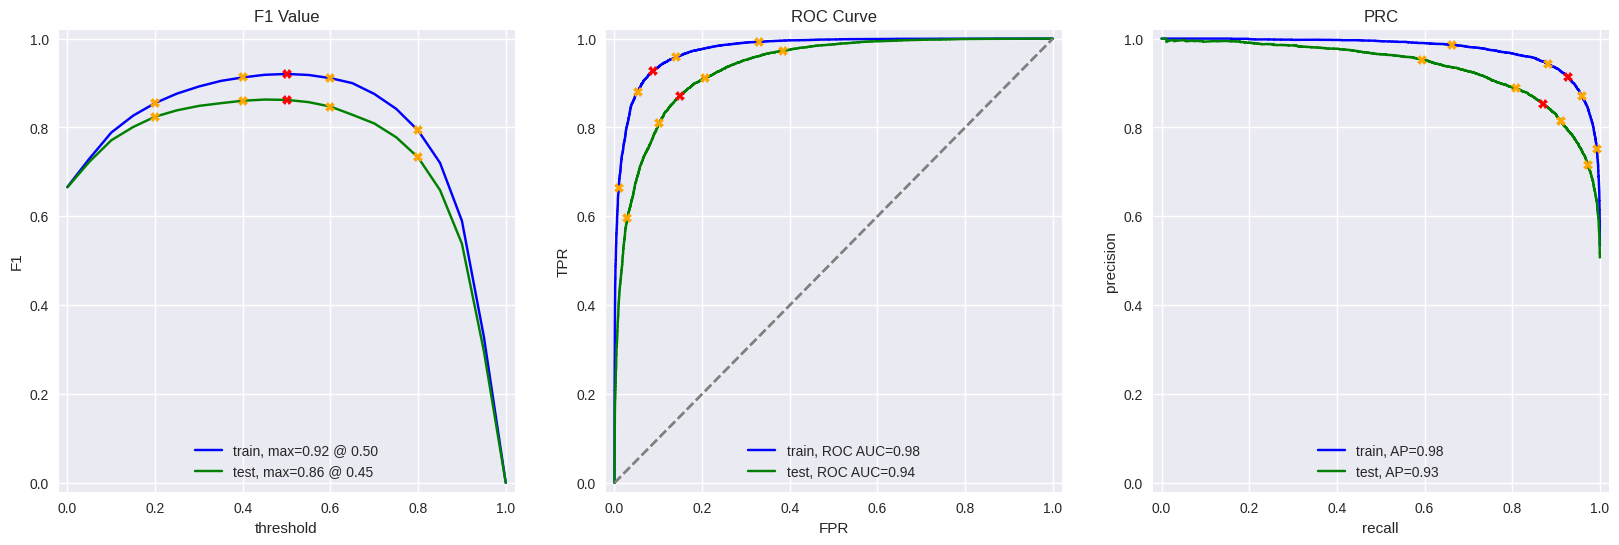

In [25]:
# Step 1: Preprocess the training and test data
df_reviews_train['review_processed'] = df_reviews_train['review'].apply(text_preprocessing_3)
df_reviews_test['review_processed'] = df_reviews_test['review'].apply(text_preprocessing_3)

# Step 2: Vectorize the reviews
vectorizer_4 = TfidfVectorizer(max_features=5000)  # Limit to 5000 features
X_train_vec_4 = vectorizer_4.fit_transform(df_reviews_train['review_processed'])
X_test_vec_4 = vectorizer_4.transform(df_reviews_test['review_processed'])

# Step 3: Create and train the LGBMClassifier model
model_4 = LGBMClassifier()
model_4.fit(X_train_vec_4, train_target)

# Step 4: Make predictions on the test data
predictions_4 = model_4.predict(X_test_vec_4)

# Step 5: Evaluate the model
eval_results_4 = evaluate_model(model_4, X_train_vec_4, train_target, X_test_vec_4, test_target)

This model has a fairly positive performance, although it is lower than that of models 2 and 3, achieving an accuracy of 86% and an F1 score of 0.86 for the test data. Additionally, we note that this model exhibits slight overfitting, which is lower than the overfitting seen in models 2 and 3.

This model already meets the requirements (F1 > 0.85), however, we will analyze the behavior of a more recent model.

###  Modelo 9 - BERT

In [26]:
import torch
import transformers

In [27]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [28]:
# Function to convert text to embeddings using BERT
def BERT_text_to_embeddings(texts, max_length=30, batch_size=9, force_device=None, disable_progress_bar=False):
    ids_list = []
    attention_mask_list = []

    # Convert text to token ids and attention masks
    for text in texts:
        # Encode the text using the BERT tokenizer
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        ids_list.append(encoded['input_ids'].squeeze().tolist())
        attention_mask_list.append(encoded['attention_mask'].squeeze().tolist())
    
    # Set the execution device
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using device {device}.')
    
    # Get embeddings in batches
    embeddings = []
    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
        ids_batch = torch.LongTensor(ids_list[batch_size * i: batch_size * (i + 1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size * i: batch_size * (i + 1)]).to(device)
        
        with torch.no_grad():
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
            embeddings.append(batch_embeddings[0][:, 0, :].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [29]:
# Execution of the function on CPU

sample_size = 10000  # or any smaller value
df_reviews_train_sample = df_reviews_train['review_norm'][:sample_size]
train_features_9 = BERT_text_to_embeddings(df_reviews_train_sample, force_device='cpu')


Using device cpu.


  0%|          | 0/1112 [00:00<?, ?it/s]

In [30]:
# Generate embeddings for the test set
df_reviews_test_sample = df_reviews_test['review_norm'][:sample_size]
test_features_9 = BERT_text_to_embeddings(df_reviews_test_sample, force_device='cpu')

Using device cpu.


  0%|          | 0/1112 [00:00<?, ?it/s]

In [31]:
np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)
print("Embeddings saved in 'features_9.npz'")

Embeddings saved in 'features_9.npz'


In [32]:
# Save training and test embeddings in a compressed file
np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)
print("Training and test embeddings saved in 'features_9.npz'")

Training and test embeddings saved in 'features_9.npz'


In [33]:
# Load the data from 'features_9.npz'
with np.load('features_9.npz') as data:
    train_features_9 = data['train_features_9']
    test_features_9 = data['test_features_9']

print("Embeddings loaded successfully")

Embeddings loaded successfully


In [34]:
# Step 2: Define and train the model
model_9 = LogisticRegression(max_iter=10000)  # Increase the number of iterations to ensure convergence
model_9.fit(train_features_9, df_reviews_train['pos'][:sample_size])

LogisticRegression(max_iter=10000)

          train  test
Accuracy   0.76  0.70
F1         0.75  0.68
APS        0.83  0.73
ROC AUC    0.84  0.77


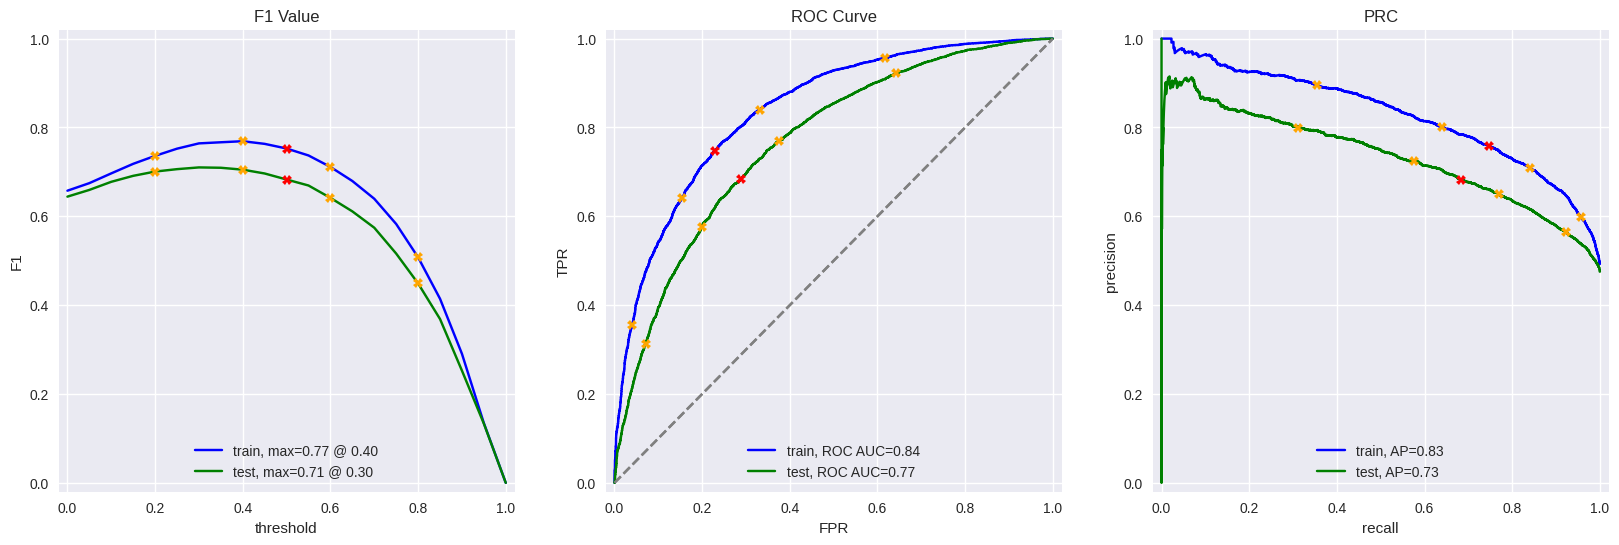

In [35]:
# Evaluate the model with the adapted function
metrics = evaluate_model(model_9, train_features_9, df_reviews_train['pos'][:sample_size], 
                         test_features_9, df_reviews_test['pos'][:sample_size])

## My reviews

In [38]:
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and fell asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode of this exciting intelligent new drama.'
], columns=['review'])


# Normalization of reviews
my_reviews['review_norm'] = my_reviews['review'].str.lower()  # Convert to lowercase
my_reviews['review_norm'] = my_reviews['review_norm'].str.replace(r'\d+', '', regex=False)  # Remove numbers
my_reviews['review_norm'] = my_reviews['review_norm'].str.replace(r'[^\w\s]', '', regex=False)  # Remove punctuation

# View the first rows to verify normalization
print(my_reviews[['review', 'review_norm']].head())


                                              review  \
0    I did not simply like it, not my kind of movie.   
1  Well, I was bored and fell asleep in the middl...   
2             I was really fascinated with the movie   
3  Even the actors looked really old and disinter...   
4  I didn't expect the reboot to be so good! Writ...   

                                         review_norm  
0    i did not simply like it, not my kind of movie.  
1  well, i was bored and fell asleep in the middl...  
2             i was really fascinated with the movie  
3  even the actors looked really old and disinter...  
4  i didn't expect the reboot to be so good! writ...  


### Model 2

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

# We prepare the vectorizer and transform the reviews
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(my_reviews['review_norm'])  # Features
y = [0, 1, 1, 0, 1, 1, 0, 1]  # Example binary labels for the reviews

# We split the data into training and testing sets (optional, just for demonstration)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# We initialize the DummyClassifier and fit it with the training data
dummy_model = DummyClassifier(strategy='most_frequent')
dummy_model.fit(X_train, y_train)

# Now, we use the model to make predictions
my_reviews_pred_prob = dummy_model.predict_proba(X_test)[:, 1]  # Probability of class 1

# We print the predictions alongside the reviews
for i, review in enumerate(my_reviews['review_norm'].iloc[:len(my_reviews_pred_prob)]):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')


0.00:  i did not simply like it, not my kind of movie.
0.00:  well, i was bored and felt asleep in the middle of the movie.


This model is not effective; it couldn't process the reviews correctly, so it is not reliable if precision is desired.

### Model 3

In [50]:
# Predictions with the model for new reviews
my_reviews_tfidf = vectorizer_3.transform(my_reviews['review_norm'])

# Make predictions with the trained model
my_reviews_pred_prob = model_3.predict_proba(my_reviews_tfidf)[:, 1]

# Display predictions along with the text of the reviews
for i, review in enumerate(my_reviews['review']):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')


0.25:  I did not simply like it, not my kind of movie.
0.23:  Well, I was bored and felt asleep in the middle of the movie.
0.60:  I was really fascinated with the movie
0.40:  Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.
0.40:  I didn't expect the reboot to be so good! Writers really cared about the source material
0.79:  The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see myself going to see it again.
0.05:  What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won't like this!
0.95:  Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.


We can notice a significant improvement, but precision needs to be enhanced due to comments like: "0.79: The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see myself going to see it again," which is highly rated but doesn't reflect the actual review.

### Model 4

In [52]:
# Predictions with the model for new reviews
my_reviews_tfidf = vectorizer_4.transform(my_reviews['review_norm'])

# Make predictions with the trained model
my_reviews_pred_prob = model_4.predict_proba(my_reviews_tfidf)[:, 1]

# Display the predictions along with the review text
for i, review in enumerate(my_reviews['review']):### Model 4
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.62:  I did not simply like it, not my kind of movie.
0.47:  Well, I was bored and felt asleep in the middle of the movie.
0.71:  I was really fascinated with the movie
0.70:  Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.
0.74:  I didn't expect the reboot to be so good! Writers really cared about the source material
0.86:  The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see myself going to see it again.
0.27:  What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won't like this!
0.82:  Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.


### Modelo 9

In [53]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.41:  i did not simply like it, not my kind of movie.
0.10:  well, i was bored and felt asleep in the middle of the movie.
0.55:  i was really fascinated with the movie
0.02:  even the actors looked really old and disinterested, and they got paid to be in the movie. what a so
0.14:  i didn't expect the reboot to be so good! writers really cared about the source material
0.65:  the movie had its upsides and downsides, but i feel like overall it's a decent flick. i could see my
0.04:  what a rotten attempt at a comedy. not a single joke lands, everyone acts annoying and loud, even ki
0.91:  launching on netflix was a brave move & i really appreciate being able to binge on episode after epi


Although it performs well, it is not as expected since our previous models were more accurate.

## Conclusions

Models 2 and 3 (which use NLTK or spaCy in combination with TF-IDF and Linear Regression) are the most coherent and effective. The model using LGBMClassifier is also performing well, although it's slightly behind the others. Finally, the model using BERT also offers acceptable performance, though slightly lower with this dataset.

Considering that models 2 and 3 provide the most favorable metrics, they are the optimal choices for this classification task, due to their metrics and simplicity compared to the other models.